In [ ]:
# загрузка диерктории с данными
!git clone https://github.com/pavel-blinov/RuMedBench.git

In [12]:
import pandas as pd

train = pd.read_json('/kaggle/working/RuMedBench/data/RuMedTop3/train_v1.jsonl',
                     lines=True)

test = pd.read_json('/kaggle/working/RuMedBench/data/RuMedTop3/test_v1.jsonl',
                     lines=True)

dev = pd.read_json('/kaggle/working/RuMedBench/data/RuMedTop3/dev_v1.jsonl',
                     lines=True)

In [3]:
# установка доп зависимостей
!pip install -q -U bitsandbytes
!pip install -q -U peft
!pip install -q -U accelerate
!pip install -q -U einops
!pip install -q -U safetensors

In [4]:
import torch
torch.backends.cuda.enable_mem_efficient_sdp(False)
torch.backends.cuda.enable_flash_sdp(False)

In [ ]:
from huggingface_hub import login
login(token="[YOUR TOKEN]")

In [ ]:
# загрузка квантизированной модели

import torch
from transformers import BitsAndBytesConfig

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
)
model_id = "mistralai/Mistral-7B-Instruct-v0.3"

from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

#model_4bit = AutoModelForCausalLM.from_pretrained(model_id, device_map="auto",quantization_config=quantization_config, )
tokenizer = AutoTokenizer.from_pretrained(model_id)

In [ ]:
from tqdm import tqdm
tqdm.pandas()

# получение input промптов

#prompt = '[INST]You are medical expert with great experience, who tries to find similarities in symptom descriptions and based on them genrate new similar ones. Answer only in Russian[/INST] Given the descriptions of symptoms of 5 people with same disease, try to generate similar symptom description for another 5 person with same disease starting from 6. .\n\nSymptom descriptions:\n{symptoms}\n6. '
prompt = '[INST]Continue the row of similar disease descriptions, generate new examples based on the already given descriptions, do not repeat in same words[/INST]\n{symptoms}\n6. '

def gen_sample_for_prompt(code):
    samples = train[train['code'] == code]['symptoms']
    samples = samples.sample(min(5, samples.shape[0])).values
    samples = '\n'.join([str(x+1)+'. '+i for x, i in enumerate(samples.tolist())])
    
    return prompt.format(symptoms=samples)

train_synthetic = train.copy()
train_synthetic['symptoms_prompt'] = \
    train_synthetic['code'].progress_apply(gen_sample_for_prompt)

filtr = train_synthetic['symptoms_prompt'].progress_apply(lambda x: len(tokenizer(x)['input_ids']) < 512)
train_synthetic = train_synthetic[filtr]

In [ ]:
train_synthetic.shape

In [ ]:
# generation
from tqdm import tqdm

pipe = pipeline(
        "text-generation",
        model=model_4bit,
        tokenizer=tokenizer,
        device_map="auto",
        max_length=1024,
        batch_size=16,
        do_sample=True,
        truncation=True,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id,
        repetition_penalty=1.2
)
pipe.tokenizer.pad_token_id = tokenizer.eos_token_id

results = []
CHUNK_SIZE = 16
for chunk in tqdm(range(train_synthetic.iloc[:300].shape[0] // CHUNK_SIZE + 1)):
    descr = train_synthetic[CHUNK_SIZE * chunk: CHUNK_SIZE * (chunk+1)]['symptoms_prompt'].to_list()
    res = pipe(descr, temperature=0.65, top_p=0.9)
    results += res
    
# bs 2 - time = 2:32:00
# bs 16 - time = 20:47
# bs 24 - time = 13:53

In [ ]:
import pickle

with open('gen_5_5_prompt_synth_data_v6', 'wb') as fp:
    pickle.dump(results, fp)

In [ ]:
from IPython.display import FileLink
FileLink(r'gen_5_5_prompt_synth_data_v6')

In [8]:
import pickle

with open('/kaggle/input/gen-5-5-v6/gen_5_5_prompt_synth_data_v6', 'rb') as fp:
    itemlist = pickle.load(fp)

In [9]:
# пример генерации
print(itemlist[20][0]['generated_text'])

[INST]Continue the row of similar disease descriptions, generate new examples based on the already given descriptions, do not repeat in same words[/INST]
1. Жалобы на незначительный кашель сухой, заложенность носа. На фоне лечнгния оьтмечает улучшение, но кашель сохраняется
2. Отмечает боли в лобной области головные , насморк сохраняется,
3. Состояние улучшилось , ноь периодически головные болии в шейном
4. общую слабость, чихание, боль в горле, заложенность носа, насморк. Стул, диурез в норме
5. Жалобы на боли в горле но меньше, на фоне лечения. лечение переногсит хорошо. На ЛН с *ДАТА* .
6. жалобы на тошнота, рвота, а также повышенное дыхание и простуда (насморк, бронхиальная кашаль). Лечение приостановилось из-за отсутствия эффекта
7. жалобы на головную боль, на спине, мускульно-костные боли, зуды, учащение дыхания. Замечено покраснение кожи лица и рук, выделение из носовых пазух.
8. жалобы на боль в грудной клетке, голову, понижению самочувствия, потеря веса. По красну резкую голов

In [10]:
# убираем input prompt
itemlist = [i[0]['generated_text'][i[0]['generated_text'].index('6. ')+3:] for i in itemlist]
itemlist[0]

'жалобы на болезненные чувства и затруднение ходьбой в правой стопе.\n7. Жалобы на борение с болью во всех пальцах ног. Ощущения неприятны и сильно затрудняет ходьбу.\n8. Боли в обеих ступнях, которые возникают после длительных простоях и интенсивной физической активностью. В то же время она испытывала значительную дискомфорт при движении в вертухах.\n9. Жалобы на общие боли и плохое состояние здоровья в правой руке.\n10. Боли в локтевых суставах, особенно после долгих рабочих часов. Она отмечала также ощущения дискомфорта, когда делала какие-то сложные действия.\n11. Сообщается о трудностях в ходьбе из-за болей в правом бедре. Она также сообщает о том, что эти боли усугубляются при продолжительной деятельности.\n12. Спазмы в нижних мышцах бедер, а также боли при движениях ногами. Она также сообщает о том, что ей трудно передвигаться.\n13. Проблема с резвыми болями в области плечом, особенно после использования компьютера. Она также сообщает о том, что её рука станет более тугово, чем 

In [ ]:
# сплит сгенерированных диагнозов по номеру между ними,
# удаление галлюцинаций - иногда после \n\n модель начинает переводить текст

import re

train_synthetic = train_synthetic.iloc[:304]
train_synthetic['symptoms_paraphrase'] = itemlist

train_synthetic['symptoms_paraphrase'] = \
    train_synthetic['symptoms_paraphrase']\
    .progress_apply(lambda x: x[:x.find('\n\n')])

train_synthetic['symptoms_paraphrase'] = \
    train_synthetic['symptoms_paraphrase']\
    .progress_apply(lambda x: re.split('\n\d\d. |\n\d\d. \n\d. |\n\d. ', x))

/tmp/ipykernel_33/3762896677.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_synthetic['len'] = train_synthetic['symptoms_paraphrase'].apply(len)


<Axes: >

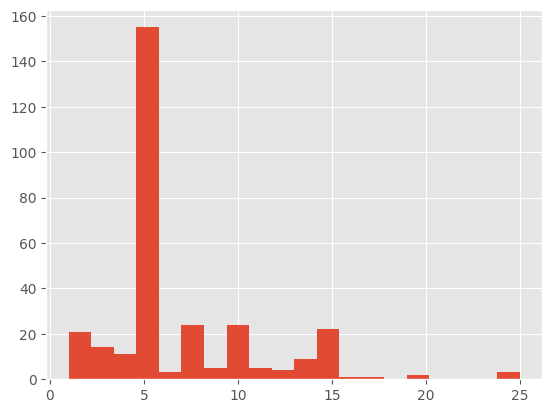

In [25]:
# гистограмма длины генерации
from matplotlib import pyplot as plt
plt.style.use('ggplot')

train_synthetic['len'] = train_synthetic['symptoms_paraphrase'].apply(len)
train_synthetic['len'].hist(bins=20)

In [26]:
train_synthetic[['symptoms_paraphrase', 'code']]

,symptoms_paraphrase,code
0,[жалобы на болезненные чувства и затруднение х...,M17
0,"[шеин.боль постепенно стала снижаться, но сопу...",M17
0,"[жара, слабость, отрыжки, метеоризм, анорексия...",M17
0,"[жалоб на боли в локтевом суставе, болящем пос...",M17
0,[ - периодические болезни желудка сопровождает...,M17
...,...,...
62,"[жалоба на изжогу, резкую боль в области сердц...",J45
62,[жара тела (38 градусов) + менее 90 беспокойны...,J45
63,[Щитовидная железа - обнаружена пузыреобразное...,M17
63,[Щитовидные железы - очень болячие при касании...,M17


In [27]:
train_synthetic = train_synthetic.explode('symptoms_paraphrase')
train_synthetic['symptoms'] = train_synthetic['symptoms_paraphrase']

In [28]:
train_synthetic

,idx,symptoms,code,symptoms_prompt,symptoms_paraphrase,len
0,q43dfecc,жалобы на болезненные чувства и затруднение хо...,M17,[INST]Continue the row of similar disease desc...,жалобы на болезненные чувства и затруднение хо...,10
0,q43dfecc,Жалобы на борение с болью во всех пальцах ног....,M17,[INST]Continue the row of similar disease desc...,Жалобы на борение с болью во всех пальцах ног....,10
0,q43dfecc,"Боли в обеих ступнях, которые возникают после ...",M17,[INST]Continue the row of similar disease desc...,"Боли в обеих ступнях, которые возникают после ...",10
0,q43dfecc,Жалобы на общие боли и плохое состояние здоров...,M17,[INST]Continue the row of similar disease desc...,Жалобы на общие боли и плохое состояние здоров...,10
0,q43dfecc,"Боли в локтевых суставах, особенно после долги...",M17,[INST]Continue the row of similar disease desc...,"Боли в локтевых суставах, особенно после долги...",10
...,...,...,...,...,...,...
63,qafb2d52,"нутрогальное болезня, головокружение, одноврем...",M17,[INST]Continue the row of similar disease desc...,"нутрогальное болезня, головокружение, одноврем...",5
63,qafb2d52,"Невысокая температура тела, дискомфортация в н...",M17,[INST]Continue the row of similar disease desc...,"Невысокая температура тела, дискомфортация в н...",5
63,qafb2d52,"Общий біль, відмінний від типових для хворих л...",M17,[INST]Continue the row of similar disease desc...,"Общий біль, відмінний від типових для хворих л...",5
63,qafb2d52,"Скороченість ногів, головокружение, шум в ушах...",M17,[INST]Continue the row of similar disease desc...,"Скороченість ногів, головокружение, шум в ушах...",5


In [30]:
train_synthetic = train_synthetic.explode('symptoms_paraphrase')
train_synthetic['symptoms'] = train_synthetic['symptoms_paraphrase']

train_synthetic[['idx', 'symptoms', 'code']].to_excel('train_augmented_3', engine='openpyxl')

In [ ]:
from IPython.display import FileLink
FileLink(r'train_augmented_3')